In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
import numpy.random as random

In [2]:
df_path = "../data/application_train.csv"
df = pd.read_csv(df_path)
df.shape

(307511, 122)

In [14]:
df["DAYS_ID_PUBLISH"].name

'ORGANIZATION_TYPE'

In [15]:
class TargetEncoder:
    def __init__(self):
        self.encoder = None
        
    def fit(self, cat, target):
        colname_cat = cat.name
        colname_target = target.name
        
        concat = pd.concat([cat, target], axis=1)
        self.encoder = concat.groupby(colname_cat)[colname_target].mean()
    
    def transform(self, cat):
        target = cat.map(self.encoder)
        return target
    
    def fit_transform(self, cat, target):
        self.fit(cat, target)
        encoded = self.transform(cat)
        return encoded

In [34]:
df = df.dropna(subset=["AMT_GOODS_PRICE", "AMT_ANNUITY"])

In [35]:
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].map(lambda x:x if x != 365243 else 0)
df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df["CREDIT_GOODS_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
df["CREDIT_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]
df["EMPLOYED_BIRTH_RATIO"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]

te = TargetEncoder()
df["REGION_TARGET_ENCODED"] = te.fit_transform(df["REGION_POPULATION_RELATIVE"], df["TARGET"])
df["ORGANIZATION_TARGET_ENCODED"] = te.fit_transform(df["ORGANIZATION_TYPE"], df["TARGET"])

columns_to_use = ["DAYS_EMPLOYED", "CREDIT_INCOME_RATIO", "CREDIT_GOODS_RATIO",
                  "CREDIT_ANNUITY_RATIO", "REGION_TARGET_ENCODED",
                  "DAYS_BIRTH", "EMPLOYED_BIRTH_RATIO", "DAYS_ID_PUBLISH", "ORGANIZATION_TARGET_ENCODED"]

X = df[columns_to_use].values
y = df["TARGET"].values

In [36]:
skf = StratifiedKFold(n_splits=3)
for train_idx, test_idx in skf.split(X, y):
    train_tmp = X[train_idx]
    y_train_tmp = y[train_idx]
    Xfold3 = X[test_idx]
    yfold3 = y[test_idx]
    
skf2 = StratifiedKFold(n_splits=2)
for train_idx, test_idx in skf2.split(train_tmp, y_train_tmp):
    Xfold1 = train_tmp[train_idx]
    yfold1 = y_train_tmp[train_idx]
    Xfold2 = train_tmp[test_idx]
    yfold2 = y_train_tmp[test_idx]
    
Xfold1.shape, Xfold2.shape, Xfold3.shape, yfold1.shape, yfold2.shape, yfold3.shape

((102407, 9), (102407, 9), (102407, 9), (102407,), (102407,), (102407,))

In [49]:
old_model = RandomForestRegressor(max_depth=10, n_estimators=100, n_jobs=-1)
old_model.fit(Xfold1, yfold1)
ypred1 = old_model.predict(Xfold2)
auc = roc_auc_score(yfold2, ypred1)
print("AUC: ", auc)

AUC:  0.669248981293876


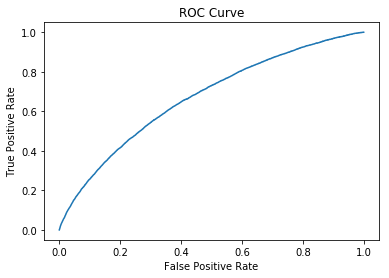

In [53]:
fpr, tpr, thresholds = roc_curve(yfold2, ypred1)
plt.figure()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr)
plt.show()

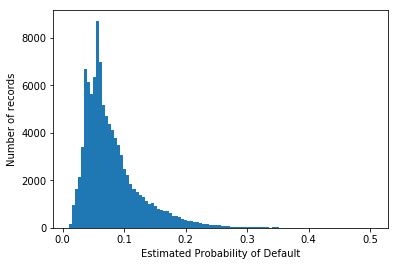

In [66]:
plt.hist(ypred1, bins=100)
plt.xlabel("Estimated Probability of Default")
plt.ylabel("Number of records")
plt.show()

In [75]:
np.where(ypred1 > 0.3)[0].shape

(243,)

In [137]:
use_idx = np.where(ypred1 < 0.15)[0]
discard_idx = np.where(ypred1 >= 0.15)[0]

Xnew = Xfold2[use_idx, :]
ynew = yfold2[use_idx]

Xdiscard = Xfold2[discard_idx, :]
ydiscard = yfold2[discard_idx]
ypred_discard = ypred1[discard_idx]

In [138]:
class SamplingRegressor:
    def __init__(self, data, ypred, base_estimator, nsample=200):
        self.nsample = nsample
        self.clfs = [base_estimator for i in range(nsample)]
        self.discarded = data
        self.samples = [random.binomial(1, ypred) for i in range(nsample)]
        self.X = None
        self.y = []
        
    def fit(self, X, y):
        self.X = np.vstack([X, self.discarded])
        self.y = [np.hstack([y, s]) for s in self.samples]
        for i, clf in enumerate(self.clfs):
            clf.fit(self.X, self.y[i])
            percentage = (i+1) / self.nsample * 100
            sys.stdout.write(f"\r{percentage:.2f} percent finished")
        print()
            
    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for clf in self.clfs:
            preds += clf.predict(X)
        return preds / self.nsample
        

In [139]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1)
sr = SamplingRegressor(Xdiscard, ypred_discard, rf, 1000)
sr.fit(Xnew, ynew)
print("Fit finished")
ypred2 = sr.predict(Xfold3)
auc2 = roc_auc_score(yfold3, ypred2)
print("AUC: ", auc2)

100.00 percent finished
Fit finished
AUC:  0.6513131247988897


In [140]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1)
rf.fit(Xnew, ynew)
ypred3 = rf.predict(Xfold3)
auc3 = roc_auc_score(yfold3, ypred3)
print("AUC: ", auc3)

AUC:  0.6497322269641183


In [142]:
rf2 = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1)
rf2.fit(Xfold2, yfold2)
ypred4 = rf2.predict(Xfold3)
auc4 = roc_auc_score(yfold3, ypred4)
print("AUC: ", auc4)

AUC:  0.6531068380273901


In [160]:
idx = np.where(ypred4 - ypred3 > 0.1)[0]
ypred3[idx] < 0.15

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [154]:
(ypred2[np.where(ypred4 - ypred3 > 0.1)[0]] > 0.15).mean()

0.9885844748858448

In [164]:
fpr_v, tpr_v, thresholds_v = roc_curve(yfold3, ypred4)
fpr_1, tpr_1, thresholds_1 = roc_curve(yfold3, ypred3)
fpr_2, tpr_2, thresholds_2 = roc_curve(yfold3, ypred2)
plt.figure()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr_v, tpr_v, color="red", label="Validation Model")
plt.plot(fpr_1, tpr_1, color="blue", label="New Model1")
plt.plot(fpr_2, tpr_2, color="green", label="New Model2")
plt.legend()
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.savefig("GCI Final Report_files/ROC_CURVE.png")